# Store Sales - Model Training

The notebook is intended to explore different models for the Time Series Forecasting of the data contained in `data/store_sales`.

**NOTE:** Ensure to download also the `train.csv` from the following Kaggle Competition: [Stores Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data).

# Setup Notebooks

## Imports

In [1]:
# Import Standard Libraries
import os
import pandas as pd
from pathlib import Path
from dynaconf import Dynaconf
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression

# Import Package Modules
from src.exploratory_data_analysis.exploratory_data_analysis_utils import (
    set_plot_characteristics,
    plot_time_series,
    plot_predictions_vs_time_series
)
from src.data_preparation.data_preparation_utils import (
    group_avg_column_by_frequency
)

## Define Configurations

In [2]:
# Retrieve root path
root_path = Path(os.getcwd()).parents[1]

# Read EDA configuration
eda_config = Dynaconf(settings_files=[root_path / 'configuration' / 'store_sales_config.toml'], 
                      environment=True, 
                      env='eda')

# Extract configurations
data_paths = eda_config['data_paths']

## Set Plots Characteristics

In [3]:
set_plot_characteristics(eda_config['plot_settings'])

[09/23/2024 21:44:05 - exploratory_data_analysis_utils] INFO - set_plot_characteristics - Start
[09/23/2024 21:44:05 - exploratory_data_analysis_utils] INFO - set_plot_characteristics - Creating theme parameters
[09/23/2024 21:44:05 - exploratory_data_analysis_utils] INFO - set_plot_characteristics - End


# Read Data

In [4]:
# Read data with parse dates
holidays_data = pd.read_csv(root_path / data_paths['holidays_data'], parse_dates=['date'], date_format='%Y-%m-%d')
oil_data = pd.read_csv(root_path / data_paths['oil_data'], parse_dates=['date'], date_format='%Y-%m-%d')
stores_data = pd.read_csv(root_path / data_paths['stores_data'])
transactions_data = pd.read_csv(root_path / data_paths['transactions_data'], parse_dates=['date'], date_format='%Y-%m-%d')
train_data = pd.read_csv(root_path / data_paths['train_data'], parse_dates=['date'], date_format='%Y-%m-%d')
test_data = pd.read_csv(root_path / data_paths['test_data'], parse_dates=['date'], date_format='%Y-%m-%d')

# Model Training

## Deterministic Process with Linear Regression

### Data Preparation

In [5]:
# Group transactions by week
transactions_data_weekly = group_avg_column_by_frequency(data=transactions_data, 
                                                         key='date', 
                                                         column='transactions', 
                                                         frequency='W')

[09/23/2024 21:44:07 - data_preparation_utils] INFO - group_avg_column_by_frequency - Start
[09/23/2024 21:44:07 - data_preparation_utils] INFO - group_avg_column_by_frequency - key: date | frequency: W | column: transactions
[09/23/2024 21:44:07 - data_preparation_utils] INFO - group_avg_column_by_frequency - End


In [6]:
# Create the DeterministicProcess object
transactions_dp = DeterministicProcess(index=transactions_data_weekly['date'], 
                                       constant=True, 
                                       order=1, 
                                       drop=True)

# Manually set index frequency
transactions_dp.index.freq = 'W'

In [7]:
# Create x & y
transactions_x = transactions_dp.in_sample()
transactions_y = transactions_data_weekly['transactions'].copy()

In [8]:
# Copy the index to the target 
transactions_y.index = transactions_x.index

### Model Training

In [9]:
# Instance and fit a linear regression model
transactions_model_lr = LinearRegression(fit_intercept=False)
transactions_model_lr.fit(transactions_x, transactions_y)

LinearRegression(fit_intercept=False)

### Model Evaluation

In [10]:
# Compute predictions
transactions_y_predictions = pd.DataFrame(data={'Predictions': transactions_model_lr.predict(transactions_x)},
                                          index=transactions_x.index)

[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Start
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Extract time series and predictions
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Plot time series
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_time_series - Start
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_time_series - Plot time series
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_time_series - Set plot configurations
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_time_series - End
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Plot predicted values
[09/23/2024 21:45:11 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - End


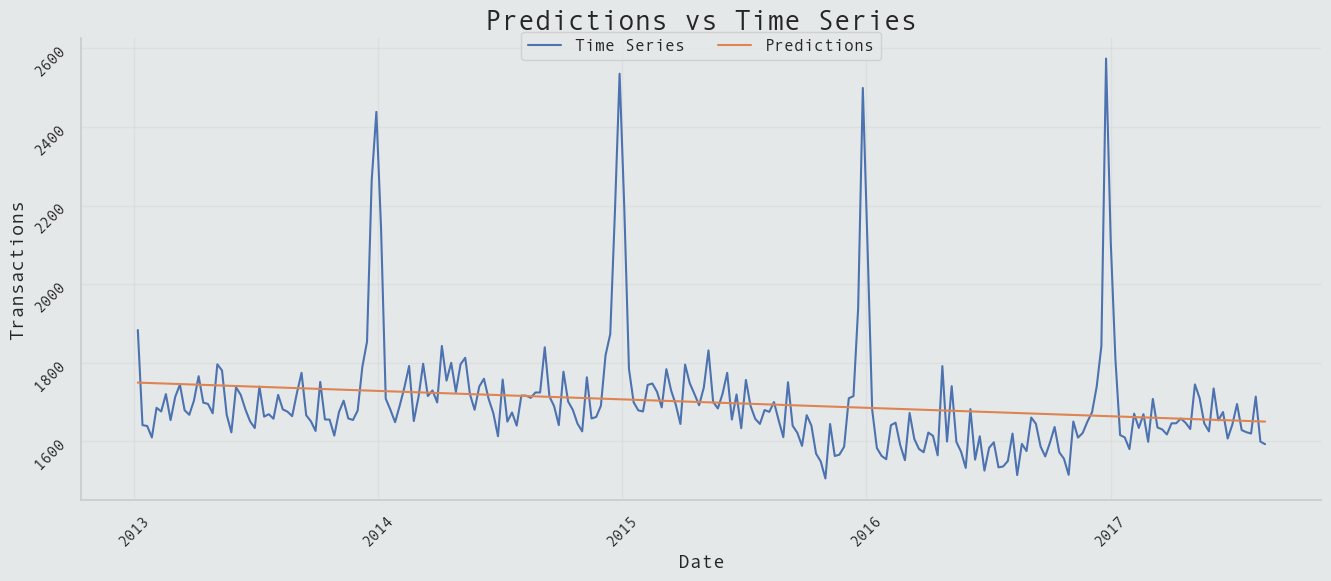

In [19]:
_ = plot_predictions_vs_time_series(data=(transactions_data_weekly, transactions_y_predictions['Predictions'].values),
                                    columns=('date', 'transactions'), 
                                    title='Predictions vs Time Series', 
                                    labels=('Date', 'Transactions', 'Predictions'), 
                                    to_plot=False)

[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Start
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Extract time series and predictions
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Plot time series
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_time_series - Start
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_time_series - Plot time series
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_time_series - Set plot configurations
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_time_series - End
[09/23/2024 21:57:35 - exploratory_data_analysis_utils] INFO - plot_predictions_vs_time_series - Plot predicted values


ValueError: array length 30 does not match index length 242

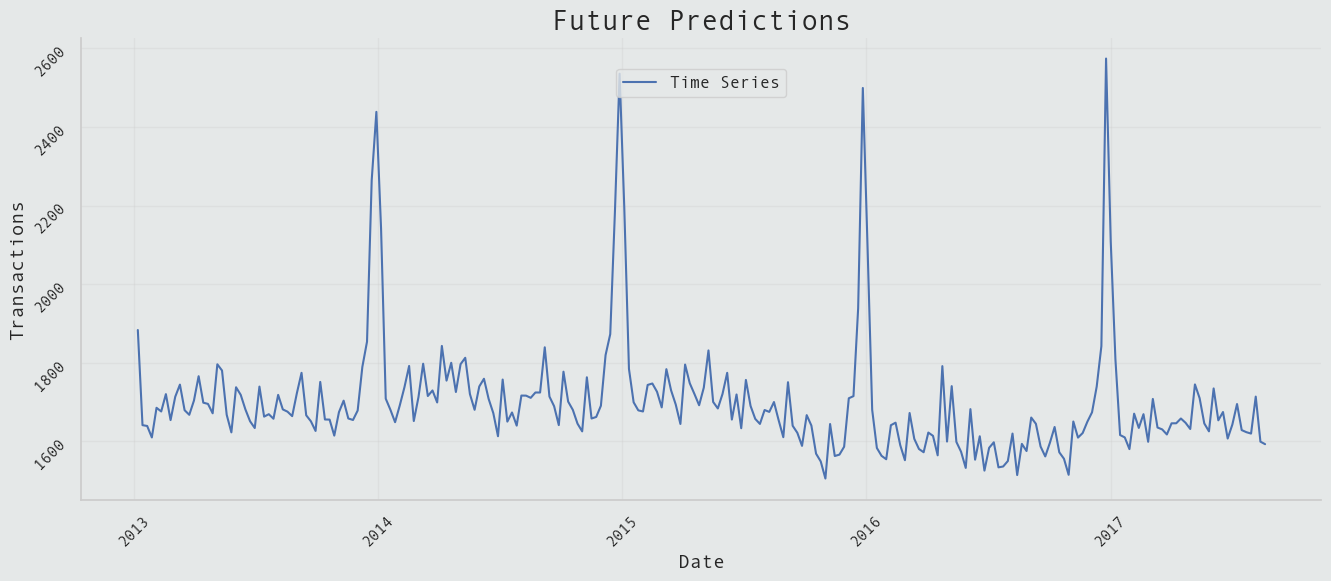

In [23]:
# Define future time steps
transactions_x_future = transactions_dp.out_of_sample(steps=30)
transactions_y_future = transactions_model_lr.predict(transactions_x_future)

_ = plot_predictions_vs_time_series(data=(transactions_data_weekly, transactions_y_future),
                                    columns=('date', 'transactions'), 
                                    title='Future Predictions', 
                                    labels=('Date', 'Transactions', 'Predictions'), 
                                    to_plot=False)